# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.58KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

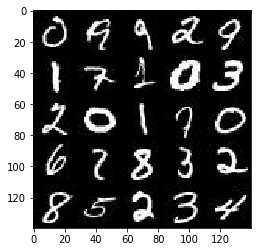

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

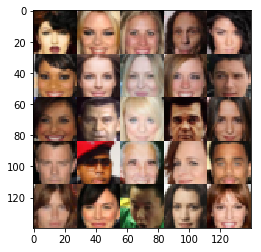

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'real_inputs')
    real_z = tf.placeholder(tf.float32, (None, z_dim), name = 'real_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')
    
    return real_inputs, real_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [10]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse = reuse):
        layer1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same')
        layer1 = tf.maximum(alpha * layer1, layer1)
        
        layer2 = tf.layers.conv2d(layer1, 64, 5, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = tf.maximum(alpha * layer2, layer2)
        
        layer3 = tf.layers.conv2d(layer2, 128, 5, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = tf.maximum(alpha * layer3, layer3)
        
        layer4 = tf.layers.conv2d(layer3, 256, 5, strides=2, padding='same')
        layer4 = tf.layers.batch_normalization(layer4, training=True)
        layer4 = tf.maximum(alpha * layer4, layer4)

        # Flatten it
        flat = tf.reshape(layer4, (-1, 2*2*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [28]:
def generator(z, out_channel_dim, training = True, alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse = not training):
        x = tf.layers.dense(z, 4*4*512)
        
        layer1 = tf.reshape(x, (-1, 4, 4, 512))
        layer1 = tf.layers.batch_normalization(layer1, training=training)
        layer1 = tf.maximum(alpha * layer1, layer1)
        
        layer2 = tf.layers.conv2d_transpose(layer1, 128, 4, strides=1, padding='valid')
        layer2 = tf.layers.batch_normalization(layer2, training=training)
        layer2 = tf.maximum(alpha * layer2, layer2)
        
        layer3 = tf.layers.conv2d_transpose(layer2, 64, 5, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=training)
        layer3 = tf.maximum(alpha * layer3, layer3)
        
        layer4 = tf.layers.conv2d_transpose(layer3, 32, 5, strides=2, padding='same')
        layer4 = tf.layers.batch_normalization(layer4, training=training)
        layer4 = tf.maximum(alpha * layer4, layer4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(layer4, out_channel_dim, 3, strides=1, padding='same')
        # 28x28x3 
        
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [30]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    discriminator_loss = d_loss_real + d_loss_fake

    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
   
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [44]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train = tf.trainable_variables()
    discriminator_var = [x for x in train if x.name.startswith('discriminator')]
    generator_var = [x for x in train if x.name.startswith('generator')]
    
    update = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    generator_updates = [op for op in update if op.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(generator_updates):
        discrimiator_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_var)
        generator_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_var)
    
    return discrimiator_opt, generator_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [45]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [46]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    
    real_inputs, real_z, learning_rate_in = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(real_inputs, real_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={ real_inputs: batch_images, real_z: batch_z, learning_rate_in: learning_rate })
                _ = sess.run(g_opt, feed_dict={ real_z: batch_z, learning_rate_in: learning_rate })
                
                if steps % print_every == 0:
                    d_loss_train = d_loss.eval({
                        real_z: batch_z,
                        real_inputs: batch_images
                    })
                    g_loss_train = g_loss.eval({
                        real_z: batch_z
                    })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(d_loss_train),
                         "Generator Loss: {:.4f}".format(g_loss_train))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, real_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4196... Generator Loss: 3.3481
Epoch 1/2... Discriminator Loss: 0.9624... Generator Loss: 2.5516
Epoch 1/2... Discriminator Loss: 0.4919... Generator Loss: 2.1788
Epoch 1/2... Discriminator Loss: 1.1897... Generator Loss: 0.5656
Epoch 1/2... Discriminator Loss: 0.9785... Generator Loss: 2.0077
Epoch 1/2... Discriminator Loss: 1.5621... Generator Loss: 0.3787
Epoch 1/2... Discriminator Loss: 1.2234... Generator Loss: 0.6288
Epoch 1/2... Discriminator Loss: 0.3972... Generator Loss: 3.7518
Epoch 1/2... Discriminator Loss: 0.4459... Generator Loss: 2.3672
Epoch 1/2... Discriminator Loss: 1.0401... Generator Loss: 0.8127


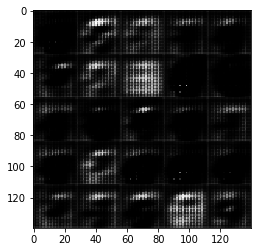

Epoch 1/2... Discriminator Loss: 1.4057... Generator Loss: 3.0093
Epoch 1/2... Discriminator Loss: 1.8614... Generator Loss: 2.4312
Epoch 1/2... Discriminator Loss: 1.7526... Generator Loss: 1.6625
Epoch 1/2... Discriminator Loss: 1.6452... Generator Loss: 0.3476
Epoch 1/2... Discriminator Loss: 1.0678... Generator Loss: 1.2275
Epoch 1/2... Discriminator Loss: 1.6304... Generator Loss: 0.5698
Epoch 1/2... Discriminator Loss: 0.6241... Generator Loss: 1.4833
Epoch 1/2... Discriminator Loss: 1.3068... Generator Loss: 0.8722
Epoch 1/2... Discriminator Loss: 0.9893... Generator Loss: 1.3849
Epoch 1/2... Discriminator Loss: 1.0433... Generator Loss: 1.5813


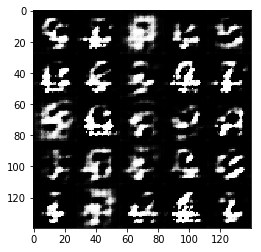

Epoch 1/2... Discriminator Loss: 1.3144... Generator Loss: 0.8740
Epoch 1/2... Discriminator Loss: 1.1752... Generator Loss: 0.8101
Epoch 1/2... Discriminator Loss: 1.1981... Generator Loss: 0.7420
Epoch 1/2... Discriminator Loss: 2.1812... Generator Loss: 0.2035
Epoch 1/2... Discriminator Loss: 1.3780... Generator Loss: 0.5979
Epoch 1/2... Discriminator Loss: 1.9207... Generator Loss: 0.4022
Epoch 1/2... Discriminator Loss: 0.8867... Generator Loss: 0.9924
Epoch 1/2... Discriminator Loss: 1.0331... Generator Loss: 1.4161
Epoch 1/2... Discriminator Loss: 1.1540... Generator Loss: 0.8196
Epoch 1/2... Discriminator Loss: 1.0613... Generator Loss: 0.7119


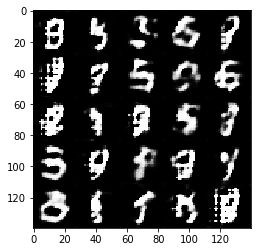

Epoch 1/2... Discriminator Loss: 1.7085... Generator Loss: 0.4032
Epoch 1/2... Discriminator Loss: 1.3229... Generator Loss: 0.5639
Epoch 1/2... Discriminator Loss: 0.9938... Generator Loss: 0.9974
Epoch 1/2... Discriminator Loss: 1.0472... Generator Loss: 0.7795
Epoch 1/2... Discriminator Loss: 2.1528... Generator Loss: 0.2199
Epoch 1/2... Discriminator Loss: 1.1684... Generator Loss: 1.1067
Epoch 1/2... Discriminator Loss: 1.2824... Generator Loss: 0.5336
Epoch 1/2... Discriminator Loss: 1.2562... Generator Loss: 0.6295
Epoch 1/2... Discriminator Loss: 1.5951... Generator Loss: 0.5050
Epoch 1/2... Discriminator Loss: 1.2536... Generator Loss: 1.3894


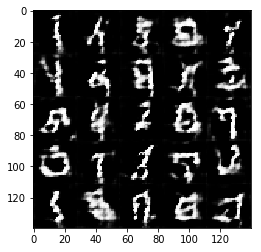

Epoch 1/2... Discriminator Loss: 1.5498... Generator Loss: 0.5767
Epoch 1/2... Discriminator Loss: 1.1390... Generator Loss: 0.8850
Epoch 1/2... Discriminator Loss: 2.2194... Generator Loss: 0.2067
Epoch 1/2... Discriminator Loss: 1.0436... Generator Loss: 1.0568
Epoch 1/2... Discriminator Loss: 1.5102... Generator Loss: 0.4861
Epoch 1/2... Discriminator Loss: 1.1345... Generator Loss: 0.6669
Epoch 1/2... Discriminator Loss: 1.4647... Generator Loss: 0.8383
Epoch 1/2... Discriminator Loss: 1.5311... Generator Loss: 0.4329
Epoch 1/2... Discriminator Loss: 1.1702... Generator Loss: 0.6808
Epoch 1/2... Discriminator Loss: 1.5014... Generator Loss: 0.4461


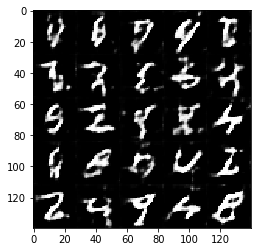

Epoch 1/2... Discriminator Loss: 1.3902... Generator Loss: 2.1116
Epoch 1/2... Discriminator Loss: 1.1005... Generator Loss: 0.8101
Epoch 1/2... Discriminator Loss: 0.9658... Generator Loss: 1.2208
Epoch 1/2... Discriminator Loss: 0.9716... Generator Loss: 1.1329
Epoch 1/2... Discriminator Loss: 1.8338... Generator Loss: 1.6833
Epoch 1/2... Discriminator Loss: 0.9292... Generator Loss: 1.1846
Epoch 1/2... Discriminator Loss: 1.4308... Generator Loss: 1.1784
Epoch 1/2... Discriminator Loss: 1.2079... Generator Loss: 2.0291
Epoch 1/2... Discriminator Loss: 1.3222... Generator Loss: 0.6647
Epoch 1/2... Discriminator Loss: 1.4882... Generator Loss: 0.4301


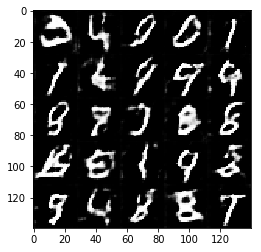

Epoch 1/2... Discriminator Loss: 1.1415... Generator Loss: 1.0415
Epoch 1/2... Discriminator Loss: 1.4071... Generator Loss: 1.0054
Epoch 1/2... Discriminator Loss: 1.1629... Generator Loss: 0.9298
Epoch 1/2... Discriminator Loss: 1.4792... Generator Loss: 0.5047
Epoch 1/2... Discriminator Loss: 2.0669... Generator Loss: 0.2669
Epoch 1/2... Discriminator Loss: 1.0880... Generator Loss: 0.7399
Epoch 1/2... Discriminator Loss: 1.4060... Generator Loss: 1.1991
Epoch 1/2... Discriminator Loss: 1.4252... Generator Loss: 0.5086
Epoch 1/2... Discriminator Loss: 1.5852... Generator Loss: 0.3789
Epoch 1/2... Discriminator Loss: 1.9777... Generator Loss: 0.2627


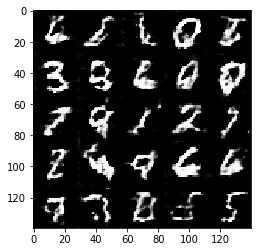

Epoch 1/2... Discriminator Loss: 1.4911... Generator Loss: 2.5619
Epoch 1/2... Discriminator Loss: 1.3349... Generator Loss: 0.5843
Epoch 1/2... Discriminator Loss: 1.2177... Generator Loss: 0.7024
Epoch 1/2... Discriminator Loss: 1.2732... Generator Loss: 0.9589
Epoch 1/2... Discriminator Loss: 0.8031... Generator Loss: 1.3316
Epoch 1/2... Discriminator Loss: 1.4243... Generator Loss: 0.5494
Epoch 1/2... Discriminator Loss: 1.3955... Generator Loss: 0.5028
Epoch 1/2... Discriminator Loss: 1.0521... Generator Loss: 0.9233
Epoch 1/2... Discriminator Loss: 0.8143... Generator Loss: 1.5287
Epoch 1/2... Discriminator Loss: 0.9270... Generator Loss: 0.9584


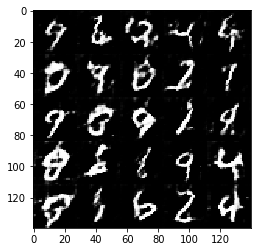

Epoch 1/2... Discriminator Loss: 1.2495... Generator Loss: 0.6189
Epoch 1/2... Discriminator Loss: 1.1829... Generator Loss: 0.6853
Epoch 1/2... Discriminator Loss: 1.5071... Generator Loss: 0.4518
Epoch 1/2... Discriminator Loss: 1.0979... Generator Loss: 1.5340
Epoch 1/2... Discriminator Loss: 1.8431... Generator Loss: 0.3287
Epoch 1/2... Discriminator Loss: 0.6544... Generator Loss: 1.5613
Epoch 1/2... Discriminator Loss: 2.0055... Generator Loss: 0.2918
Epoch 1/2... Discriminator Loss: 1.0155... Generator Loss: 0.8652
Epoch 1/2... Discriminator Loss: 1.2433... Generator Loss: 0.7169
Epoch 1/2... Discriminator Loss: 0.9648... Generator Loss: 1.0684


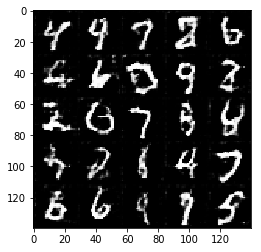

Epoch 1/2... Discriminator Loss: 1.5201... Generator Loss: 0.4866
Epoch 1/2... Discriminator Loss: 0.8205... Generator Loss: 1.3151
Epoch 1/2... Discriminator Loss: 1.6530... Generator Loss: 0.4103
Epoch 2/2... Discriminator Loss: 1.7196... Generator Loss: 0.3377
Epoch 2/2... Discriminator Loss: 1.2608... Generator Loss: 1.4406
Epoch 2/2... Discriminator Loss: 1.2723... Generator Loss: 0.6140
Epoch 2/2... Discriminator Loss: 1.1811... Generator Loss: 1.0038
Epoch 2/2... Discriminator Loss: 0.9637... Generator Loss: 1.0192
Epoch 2/2... Discriminator Loss: 1.4929... Generator Loss: 0.5800
Epoch 2/2... Discriminator Loss: 1.4499... Generator Loss: 0.5158


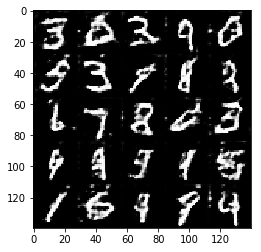

Epoch 2/2... Discriminator Loss: 1.0060... Generator Loss: 1.0812
Epoch 2/2... Discriminator Loss: 1.2620... Generator Loss: 0.6853
Epoch 2/2... Discriminator Loss: 1.9351... Generator Loss: 0.2765
Epoch 2/2... Discriminator Loss: 1.5974... Generator Loss: 3.1286
Epoch 2/2... Discriminator Loss: 1.1958... Generator Loss: 0.6635
Epoch 2/2... Discriminator Loss: 0.9063... Generator Loss: 1.2235
Epoch 2/2... Discriminator Loss: 0.9536... Generator Loss: 0.9351
Epoch 2/2... Discriminator Loss: 1.5770... Generator Loss: 0.4832
Epoch 2/2... Discriminator Loss: 1.2205... Generator Loss: 0.6809
Epoch 2/2... Discriminator Loss: 1.0227... Generator Loss: 1.1737


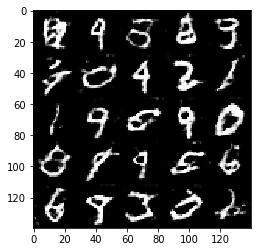

Epoch 2/2... Discriminator Loss: 0.9614... Generator Loss: 0.9164
Epoch 2/2... Discriminator Loss: 1.2282... Generator Loss: 0.7965
Epoch 2/2... Discriminator Loss: 1.3358... Generator Loss: 0.5459
Epoch 2/2... Discriminator Loss: 1.0942... Generator Loss: 0.9526
Epoch 2/2... Discriminator Loss: 2.0146... Generator Loss: 0.2499
Epoch 2/2... Discriminator Loss: 1.6403... Generator Loss: 0.3866
Epoch 2/2... Discriminator Loss: 1.2301... Generator Loss: 0.6932
Epoch 2/2... Discriminator Loss: 1.1895... Generator Loss: 0.6755
Epoch 2/2... Discriminator Loss: 2.0969... Generator Loss: 0.2521
Epoch 2/2... Discriminator Loss: 1.2179... Generator Loss: 0.6681


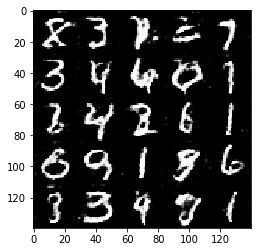

Epoch 2/2... Discriminator Loss: 0.7985... Generator Loss: 1.5391
Epoch 2/2... Discriminator Loss: 0.9539... Generator Loss: 1.0129
Epoch 2/2... Discriminator Loss: 1.9192... Generator Loss: 0.2803
Epoch 2/2... Discriminator Loss: 0.8261... Generator Loss: 1.3044
Epoch 2/2... Discriminator Loss: 1.5768... Generator Loss: 0.4672
Epoch 2/2... Discriminator Loss: 1.3082... Generator Loss: 0.5949
Epoch 2/2... Discriminator Loss: 1.9860... Generator Loss: 0.4123
Epoch 2/2... Discriminator Loss: 0.9277... Generator Loss: 1.2357
Epoch 2/2... Discriminator Loss: 1.0861... Generator Loss: 0.7962
Epoch 2/2... Discriminator Loss: 0.9284... Generator Loss: 0.9486


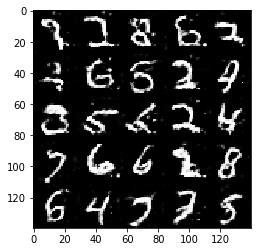

Epoch 2/2... Discriminator Loss: 1.1500... Generator Loss: 0.7735
Epoch 2/2... Discriminator Loss: 0.8536... Generator Loss: 1.2016
Epoch 2/2... Discriminator Loss: 1.1208... Generator Loss: 1.3352
Epoch 2/2... Discriminator Loss: 1.2816... Generator Loss: 0.8622
Epoch 2/2... Discriminator Loss: 1.5751... Generator Loss: 0.3999
Epoch 2/2... Discriminator Loss: 0.9153... Generator Loss: 1.1146
Epoch 2/2... Discriminator Loss: 1.1773... Generator Loss: 1.8860
Epoch 2/2... Discriminator Loss: 2.0474... Generator Loss: 0.2789
Epoch 2/2... Discriminator Loss: 1.2254... Generator Loss: 1.7040
Epoch 2/2... Discriminator Loss: 0.9643... Generator Loss: 1.5160


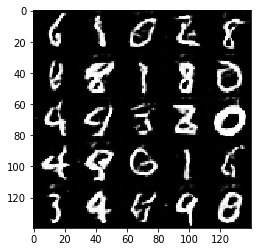

Epoch 2/2... Discriminator Loss: 1.0335... Generator Loss: 0.8356
Epoch 2/2... Discriminator Loss: 1.3953... Generator Loss: 0.5356
Epoch 2/2... Discriminator Loss: 0.9013... Generator Loss: 1.1839
Epoch 2/2... Discriminator Loss: 1.4593... Generator Loss: 0.6834
Epoch 2/2... Discriminator Loss: 1.7236... Generator Loss: 0.3591
Epoch 2/2... Discriminator Loss: 1.4973... Generator Loss: 3.1145
Epoch 2/2... Discriminator Loss: 1.9957... Generator Loss: 0.2689
Epoch 2/2... Discriminator Loss: 1.0795... Generator Loss: 1.2364
Epoch 2/2... Discriminator Loss: 1.0731... Generator Loss: 1.0895
Epoch 2/2... Discriminator Loss: 1.3211... Generator Loss: 0.5829


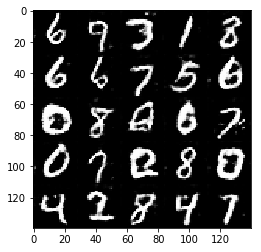

Epoch 2/2... Discriminator Loss: 1.3553... Generator Loss: 1.4419
Epoch 2/2... Discriminator Loss: 1.0574... Generator Loss: 0.8548
Epoch 2/2... Discriminator Loss: 1.6289... Generator Loss: 0.3794
Epoch 2/2... Discriminator Loss: 1.2508... Generator Loss: 0.5966
Epoch 2/2... Discriminator Loss: 0.8305... Generator Loss: 1.2087
Epoch 2/2... Discriminator Loss: 1.0302... Generator Loss: 1.0569
Epoch 2/2... Discriminator Loss: 0.9930... Generator Loss: 0.9142
Epoch 2/2... Discriminator Loss: 1.5566... Generator Loss: 0.4746
Epoch 2/2... Discriminator Loss: 2.1694... Generator Loss: 4.1600
Epoch 2/2... Discriminator Loss: 1.4080... Generator Loss: 0.5266


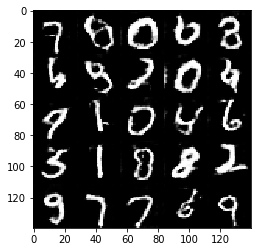

Epoch 2/2... Discriminator Loss: 1.4218... Generator Loss: 0.5521
Epoch 2/2... Discriminator Loss: 1.3405... Generator Loss: 0.6345
Epoch 2/2... Discriminator Loss: 1.4330... Generator Loss: 2.3200
Epoch 2/2... Discriminator Loss: 1.3001... Generator Loss: 2.1038
Epoch 2/2... Discriminator Loss: 1.1718... Generator Loss: 0.6788
Epoch 2/2... Discriminator Loss: 1.2651... Generator Loss: 0.8668
Epoch 2/2... Discriminator Loss: 1.6505... Generator Loss: 0.4066
Epoch 2/2... Discriminator Loss: 2.3119... Generator Loss: 0.1969
Epoch 2/2... Discriminator Loss: 1.6537... Generator Loss: 0.5803
Epoch 2/2... Discriminator Loss: 1.6793... Generator Loss: 0.3723


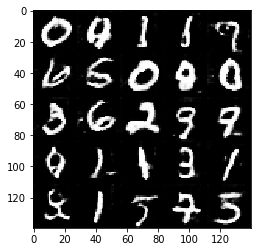

Epoch 2/2... Discriminator Loss: 1.2153... Generator Loss: 0.6393
Epoch 2/2... Discriminator Loss: 2.0118... Generator Loss: 0.2450
Epoch 2/2... Discriminator Loss: 1.0451... Generator Loss: 0.8081
Epoch 2/2... Discriminator Loss: 1.3201... Generator Loss: 0.8881
Epoch 2/2... Discriminator Loss: 0.8736... Generator Loss: 1.2599
Epoch 2/2... Discriminator Loss: 1.2623... Generator Loss: 0.7496
Epoch 2/2... Discriminator Loss: 1.3725... Generator Loss: 0.5565
Epoch 2/2... Discriminator Loss: 0.9552... Generator Loss: 0.9357
Epoch 2/2... Discriminator Loss: 1.5076... Generator Loss: 0.7669
Epoch 2/2... Discriminator Loss: 2.2890... Generator Loss: 0.2048


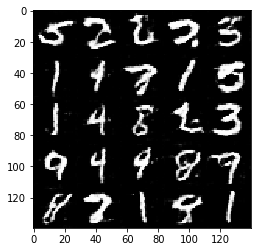

Epoch 2/2... Discriminator Loss: 1.2014... Generator Loss: 0.6666
Epoch 2/2... Discriminator Loss: 1.0448... Generator Loss: 1.0365
Epoch 2/2... Discriminator Loss: 2.3358... Generator Loss: 0.1786
Epoch 2/2... Discriminator Loss: 0.9064... Generator Loss: 1.1657
Epoch 2/2... Discriminator Loss: 1.1944... Generator Loss: 1.3028
Epoch 2/2... Discriminator Loss: 1.0519... Generator Loss: 1.3140
Epoch 2/2... Discriminator Loss: 1.1920... Generator Loss: 1.5194


In [47]:
batch_size = 64
z_dim = 128
learning_rate = 0.003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 3.4974... Generator Loss: 0.0597
Epoch 1/1... Discriminator Loss: 0.6104... Generator Loss: 7.1570
Epoch 1/1... Discriminator Loss: 0.4248... Generator Loss: 3.5973
Epoch 1/1... Discriminator Loss: 0.4506... Generator Loss: 3.7677
Epoch 1/1... Discriminator Loss: 0.8369... Generator Loss: 1.8550
Epoch 1/1... Discriminator Loss: 1.8588... Generator Loss: 0.3656
Epoch 1/1... Discriminator Loss: 0.9111... Generator Loss: 2.1353
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 0.7688... Generator Loss: 1.3021


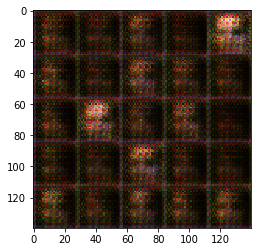

Epoch 1/1... Discriminator Loss: 2.0390... Generator Loss: 7.0660
Epoch 1/1... Discriminator Loss: 0.7922... Generator Loss: 1.7751
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.5665
Epoch 1/1... Discriminator Loss: 0.7670... Generator Loss: 2.2003
Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 0.9751... Generator Loss: 0.9364
Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 1.8958
Epoch 1/1... Discriminator Loss: 0.8446... Generator Loss: 1.0357
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 0.7646... Generator Loss: 1.6248


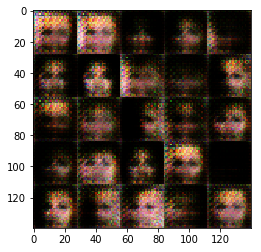

Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 0.9492
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 0.9851... Generator Loss: 1.0788
Epoch 1/1... Discriminator Loss: 0.9936... Generator Loss: 0.9542
Epoch 1/1... Discriminator Loss: 0.8753... Generator Loss: 1.1589
Epoch 1/1... Discriminator Loss: 0.6994... Generator Loss: 1.7603
Epoch 1/1... Discriminator Loss: 0.8181... Generator Loss: 1.2971
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 2.3967
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.7318


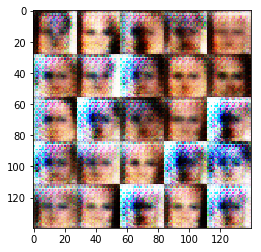

Epoch 1/1... Discriminator Loss: 1.5146... Generator Loss: 0.4502
Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 0.8519... Generator Loss: 1.2919
Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 2.2353
Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 1.5183
Epoch 1/1... Discriminator Loss: 1.0161... Generator Loss: 1.2032
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 1.6983
Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 1.1358
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 1.2247
Epoch 1/1... Discriminator Loss: 1.0427... Generator Loss: 1.1615


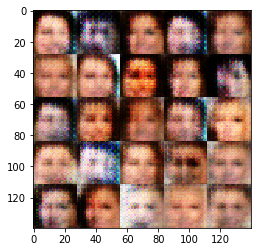

Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.8945
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 1.3840
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 1.1195
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 1.2564
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 1.0380
Epoch 1/1... Discriminator Loss: 1.0242... Generator Loss: 1.0642
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 1.3598
Epoch 1/1... Discriminator Loss: 0.9566... Generator Loss: 1.1860
Epoch 1/1... Discriminator Loss: 1.6309... Generator Loss: 2.4561
Epoch 1/1... Discriminator Loss: 1.0397... Generator Loss: 1.3537


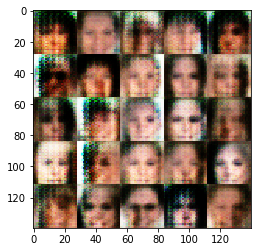

Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.9456
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 1.0048
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 1.3292
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 1.0072
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 0.9441
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 1.1223
Epoch 1/1... Discriminator Loss: 1.0210... Generator Loss: 1.3970


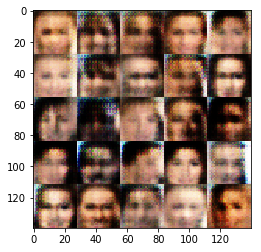

Epoch 1/1... Discriminator Loss: 1.1014... Generator Loss: 1.1630
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 0.8480
Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 0.8842
Epoch 1/1... Discriminator Loss: 1.0948... Generator Loss: 0.9516
Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 1.1167
Epoch 1/1... Discriminator Loss: 1.0540... Generator Loss: 0.9660
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 2.1043
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 1.1425
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 0.9797


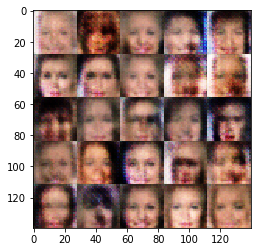

Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.9440
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 1.1382
Epoch 1/1... Discriminator Loss: 1.0107... Generator Loss: 1.1693
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 1.0187
Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 1.8351
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 1.1506
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.7837


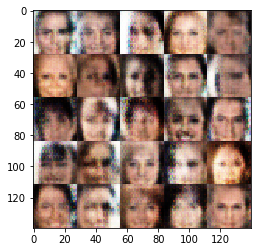

Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 0.9463
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 1.8015
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 1.2498
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.9486
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 0.8956
Epoch 1/1... Discriminator Loss: 1.1111... Generator Loss: 1.0211
Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 1.2181
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 1.0206
Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 0.9889


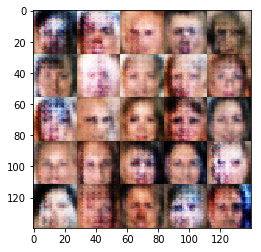

Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 1.2112
Epoch 1/1... Discriminator Loss: 1.1012... Generator Loss: 1.0833
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 1.1313
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 1.0096
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 1.0586
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.8605
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 1.3274
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.5660


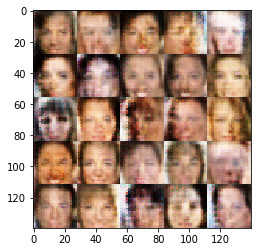

Epoch 1/1... Discriminator Loss: 1.0262... Generator Loss: 1.2745
Epoch 1/1... Discriminator Loss: 0.9740... Generator Loss: 1.1372
Epoch 1/1... Discriminator Loss: 1.0373... Generator Loss: 0.9754
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 2.2080
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 1.6208
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 1.3312


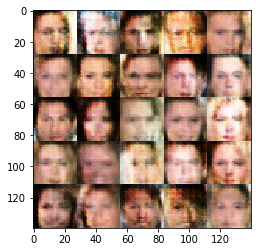

Epoch 1/1... Discriminator Loss: 1.0317... Generator Loss: 1.0678
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.0996... Generator Loss: 1.1138
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 1.2640
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 1.0432
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 0.9474... Generator Loss: 1.4992
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 1.0626
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 1.1737


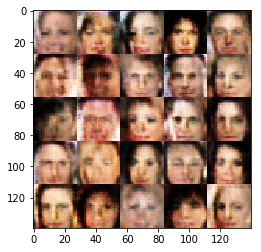

Epoch 1/1... Discriminator Loss: 0.9116... Generator Loss: 1.2162
Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 1.0896
Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 1.0963
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 1.1413
Epoch 1/1... Discriminator Loss: 1.0241... Generator Loss: 1.0203
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 1.0823
Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.8582


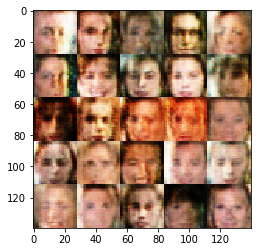

Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 0.8981
Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 0.9798
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 0.9665


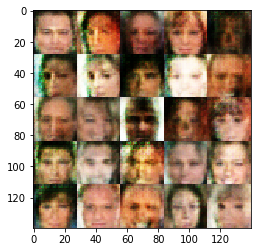

Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 1.2832
Epoch 1/1... Discriminator Loss: 1.0232... Generator Loss: 1.0414
Epoch 1/1... Discriminator Loss: 1.0141... Generator Loss: 1.1085
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 1.2926
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 1.0795


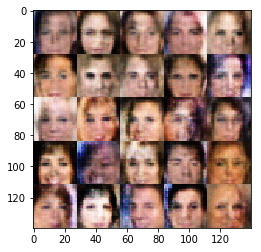

Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 1.1182
Epoch 1/1... Discriminator Loss: 1.0439... Generator Loss: 1.0269
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 1.2188
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 1.4712
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 0.9717
Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 1.1463


In [48]:
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.